In [1]:
%%capture
!pip install datasets
!pip install openai

In [2]:
from datasets import load_dataset
dataset = load_dataset('gsm8k', 'main')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Dataset gsm8k downloaded and prepared to /root/.cache/huggingface/datasets/gsm8k/main/1.1.0/37bfb08b1d4fcbb01f06b03d9e1ef5f1fcbd4d3af3d08842c50d7305091285ba. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
idx = 50
question = 'Q:' + dataset['train'][idx]['question']
standart_answer = 'The answer is ' + dataset['train'][idx]['answer'].split('####')[1]
chain_of_thought_answer = dataset['train'][idx]['answer'].split('###')[0]

standart = question + '\nA: ' + standart_answer
chain_of_thought = question + '\nA: ' + chain_of_thought_answer + standart_answer
print(chain_of_thought)

Q:Gerald spends $100 a month on baseball supplies. His season is 4 months long. He wants to use the months he's not playing baseball to save up by raking, shoveling, and mowing lawns. He charges $10 for each. How many chores does he need to average a month to save up for his supplies?
A: He needs to save up $400 because 4 x 100 = <<4*100=400>>400
He has 8 months to earn this money because 12 - 4 = <<12-4=8>>8
He needs to earn $50 a month because 400 / 8 = <<400/8=50>>50
He needs to do 5 tasks a month because 50 / 10 = <<50/10=5>>5
The answer is  5


In [4]:
import openai
from collections import defaultdict

openai.api_key = "SECRET_TOKEN"

In [5]:
N_SAMPLES = 10
standart_prompts = []
chain_of_thoughts = []

for i in range(N_SAMPLES):
    standart_prompts.append(standart + '\nQ:' + dataset['train'][i]['question'] + '\nA:')
    chain_of_thoughts.append(chain_of_thought + '\nQ:' + dataset['train'][i]['question'] + '\nA:')

print('Standart')
print(standart_prompts[0])

print('\nChain_Of_Thoughts')
print(chain_of_thoughts[0])

Standart
Q:Gerald spends $100 a month on baseball supplies. His season is 4 months long. He wants to use the months he's not playing baseball to save up by raking, shoveling, and mowing lawns. He charges $10 for each. How many chores does he need to average a month to save up for his supplies?
A: The answer is  5
Q:Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A:

Chain_Of_Thoughts
Q:Gerald spends $100 a month on baseball supplies. His season is 4 months long. He wants to use the months he's not playing baseball to save up by raking, shoveling, and mowing lawns. He charges $10 for each. How many chores does he need to average a month to save up for his supplies?
A: He needs to save up $400 because 4 x 100 = <<4*100=400>>400
He has 8 months to earn this money because 12 - 4 = <<12-4=8>>8
He needs to earn $50 a month because 400 / 8 = <<400/8=50>>50
He needs to do 5 tasks a month

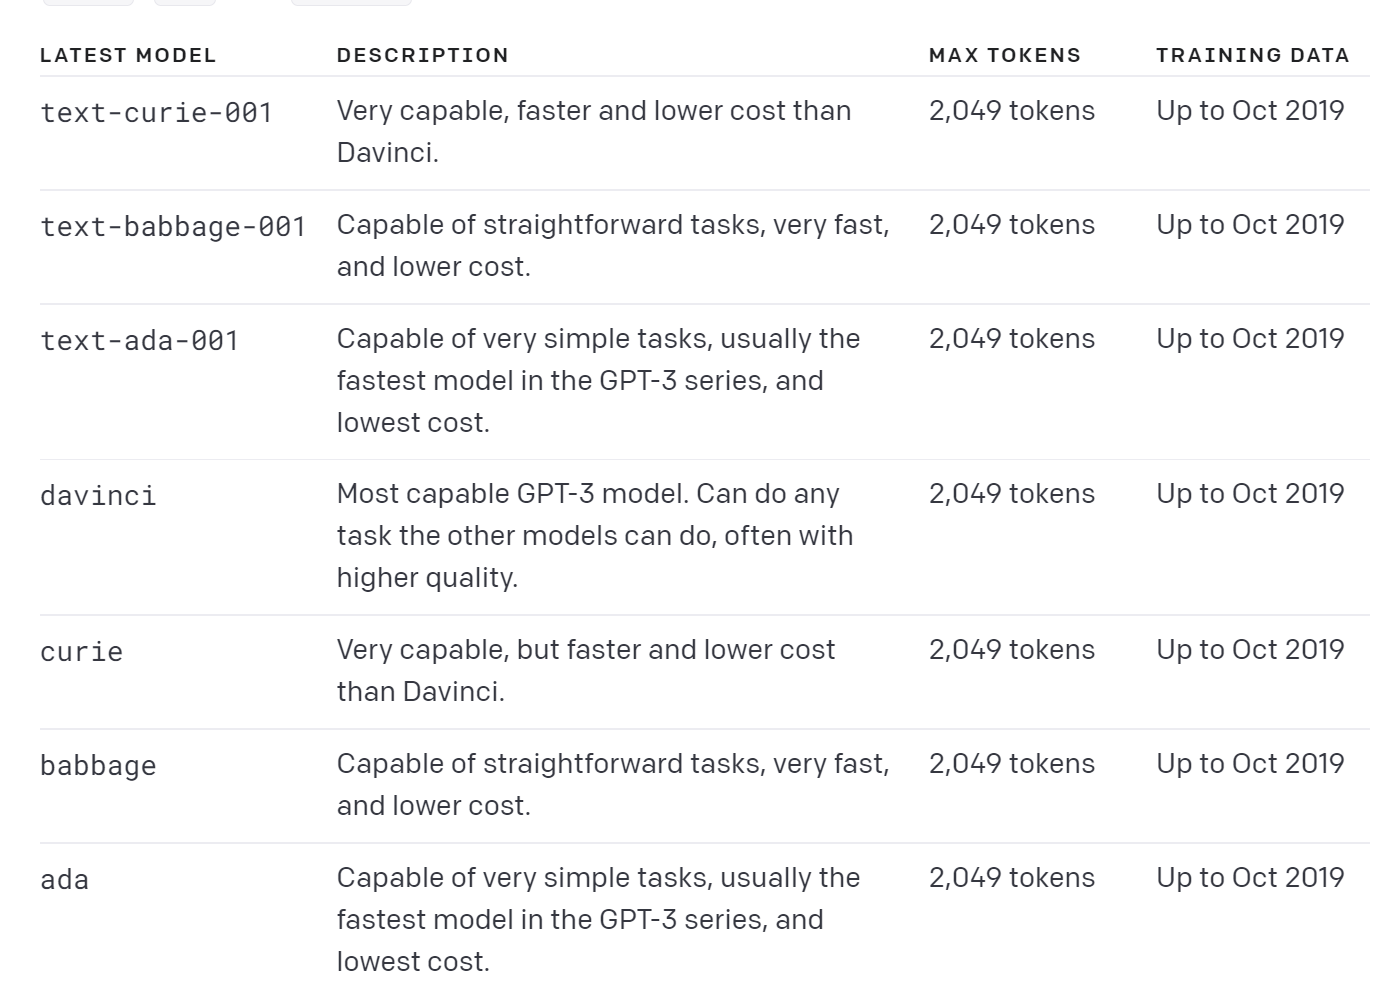

In [ ]:
models = [
    'curie', 
    'text-davinci-003',
    'text-davinci-002',
    'text-davinci-001',
    'text-curie-001',
    'text-babbage-001',
    'text-ada-001',
]

model_responses = {
    'standart' : defaultdict(list),
    'chain_of_thoughts' : defaultdict(list),
    'gold' : defaultdict(list)
}

for i in range(N_SAMPLES):
    for mode in ['standart', 'chain_of_thoughts', 'gold']:
        for model_name in tqdm(models):
            if mode == 'standart':
                prompt = standart_prompts[i]
            elif mode == 'chain_of_thoughts':
                prompt = chain_of_thoughts[i]
            elif mode == 'gold':
                model_responses[mode][model_name].append(dataset['train'][i]['answer'])
                continue

            response = openai.Completion.create(
                    model=model_name,
                    prompt=prompt,
                    temperature=0,
                    max_tokens=300,
                    top_p=1.0,
                    frequency_penalty=0.0,
                    presence_penalty=0.0,
                )
            response = response.choices[0].text

            model_responses[mode][model_name].append(response)

100%|██████████| 7/7 [00:00<00:00, 3700.55it/s]


In [8]:
model_name = 'gpt-3.5-turbo' # Most capable GPT-3.5 model and optimized for chat at 1/10th the cost of text-davinci-003.

for i in range(N_SAMPLES):
    for mode in ['standart', 'chain_of_thoughts', 'gold']:
        messages = [{"role": "system", "content": "You are a helpful assistant, that solves math problems"}]

        if mode == 'standart':
            messages += [
                    {"role": "user", "content": dataset['train'][idx]['question']},
                    {"role": "assistant", "content": standart_answer},
                    {"role": "user", "content": dataset['train'][i]['question']}
                ]
        elif mode == 'chain_of_thoughts':
            messages += [
                    {"role": "user", "content": dataset['train'][idx]['question']},
                    {"role": "assistant", "content": chain_of_thought_answer},
                    {"role": "user", "content": dataset['train'][i]['question']}
                ]
        elif mode == 'gold':
            model_responses[mode][model_name].append(dataset['train'][i]['answer'])
            continue

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=0,
            max_tokens=300,
            top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0,
        )
        response = response['choices'][0]['message']['content']
        model_responses[mode][model_name].append(response)

In [12]:
import pandas as pd
df = pd.DataFrame(model_responses).reset_index()

saved_df = pd.concat([df.explode('standart')[['index','standart']], 
           df.explode('chain_of_thoughts')[['chain_of_thoughts']],
           df.explode('gold')[['gold']]], 
    axis=1).rename(columns={'index':'model_name'}).reset_index(drop=True)
saved_df.to_csv('report.csv', index=False)

[Результаты](https://docs.google.com/spreadsheets/d/170BvdYQbiTL-rsv-DYZ48YOXxcYXgfl7-dEdZWhpxPk/edit?usp=sharing)

### Просим GPT не размышлять

In [14]:
model_responses = {
    'standart' : defaultdict(list),
    'chain_of_thoughts' : defaultdict(list),
    'gold' : defaultdict(list)
}

model_name = 'gpt-3.5-turbo'
for i in range(N_SAMPLES):
    for mode in ['standart', 'chain_of_thoughts', 'gold']:
        if mode == 'standart':
            messages = [{"role": "system", "content": "You are a helpful assistant, that solves math problems (write only answer for problem, wighout explanations)"}]
            messages += [
                    {"role": "user", "content": dataset['train'][idx]['question']},
                    {"role": "assistant", "content": standart_answer},
                    {"role": "user", "content": dataset['train'][i]['question']}
                ]
        elif mode == 'chain_of_thoughts':
            messages = [{"role": "system", "content": "You are a helpful assistant, that solves math problems"}]
            messages=[
                    {"role": "user", "content": dataset['train'][idx]['question']},
                    {"role": "assistant", "content": chain_of_thought_answer},
                    {"role": "user", "content": dataset['train'][i]['question']}
                ]
        elif mode == 'gold':
            model_responses[mode][model_name].append(dataset['train'][i]['answer'])
            continue

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=0,
            max_tokens=300,
            top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0,
        )
        response = response['choices'][0]['message']['content']
        model_responses[mode][model_name].append(response)

In [15]:
import pandas as pd
df = pd.DataFrame(model_responses).reset_index()

saved_df = pd.concat([df.explode('standart')[['index','standart']], 
           df.explode('chain_of_thoughts')[['chain_of_thoughts']],
           df.explode('gold')[['gold']]], 
    axis=1).rename(columns={'index':'model_name'}).reset_index(drop=True)
saved_df.to_csv('new_report.csv', index=False)

[Результаты](https://docs.google.com/spreadsheets/d/1P4wxzS8OE9-z4FIRo6At4mp028DLGU4Z5b7bJq54sxw/edit?usp=sharing)